# [Qubit Lattice Model](https://doi.org/10.1117/12.485960)
> _Venegas-Andraca SE, Bose S (2003)_ "Storing, processing, and retrieving an image using quantum mechanics" In: Quantum information and computation, vol 5105, pp 137–147. https://doi.org/10.1117/12.485960. International society for optics and photonics.

A naive algorithm that consists of literally copying the classical representation in quantum. Therefore, the circuit width is $2^{2n}$ for $2^{n} \times 2^{n}$ grayscale image. 

In order to encode RGB images, a lattice of qubits can be used, where each 'layer' holds the intensities of one color. The authors propose using a $R_{y}$ rotation gate to encode the pixel intensity. While this is the first formulation of quantum image storing, it has a major drawback of having large circuit width. This approach does not use quantum features like entanglement and superposition, and hence it has considerably low circuit depth.

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.result.utils import marginal_distribution
from qiskit_ibm_runtime.fake_provider import FakeMumbai
from qiskit.quantum_info import hellinger_fidelity


import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [3]:
backend = AerSimulator()

In order to determine the angle of rotation based on the intensity, we use numpy's interpolation method. This will convert our input values from the range (0, 255) to (o, $\pi$).

Interpolation:
$$
y = y_{1} + (x - x_{1}) \frac{(y_{2} - y_{1})}{(x_{2} - x_{1})}
$$

where, $(x_{1}, y_{1}) = (0, 0)$, $(x_{2}, y_{2}) = (255, \pi)$

This will give us the angles $\in [o, \pi]$ for every input value between 0 and 255.


In [3]:
# INPUT - LEGACY
def getInput(n, linear=True, verbose=False):
    side = int(math.sqrt(n))
    if linear:
        input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)
    else:
        input_vector = []
        for i in range(side):
            input_vector.extend(np.linspace(start=i*side, stop=i*side+side, num=side, dtype=int) if not i%2 else np.linspace(start=i*side+side, stop=i*side, num=side, dtype=int))
    
    if verbose:
        plt.title('Input image')
        plt.imshow(np.reshape(input_vector, (side, side)), cmap='gray')

    input_angles = np.interp(input_vector, (0, 255), (0, np.pi))
    if verbose: print(input_vector,"\n", input_angles)

    return input_vector, input_angles

In [ ]:
# INPUT
def prepareInput(n=4, input_range=(0, 255), angle_range=(0, np.pi), dist="linear", verbose=1):
    side = int(math.sqrt(n))
    if dist.lower() == "random":
        input_vector = np.random.uniform(low=0, high=255, size=n, dtype=int)
    
    elif dist.lower() == "reversing":
        input_vector = []
        init_vector = np.linspace(start=0, stop=255, num=n, dtype=int)

        for i in range(side):
            input_vector.extend(init_vector[i*side:i*side+side] if not i%2 else init_vector[i*side+side-1:i*side-1:-1])
    else:
        input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)

    input_angles = np.interp(input_vector, input_range, angle_range) 
    
    if verbose:
        plt.title('Input image')
        plt.imshow(np.reshape(input_vector, (side, side)), cmap='gray')

    return input_vector, input_angles

In [3]:
def calculate_fidelity(output_distribution, stateVec):
    # ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

    return hellinger_fidelity(output_distribution, stateVec)

In [4]:
# THRESHOLD
def getThresholdAngle(n=0.5, verbose=False):
    if verbose: print(f'{np.interp(n, (0, 255), (0, np.pi))}')
    return np.interp(n*255, (0, 255), (0, np.pi))

The encoder will simply apply the rotation gates to each qubit with appropriate angle.

$$
R_{y} = \begin{pmatrix}
cos \frac{\theta}{2} & - sin \frac{\theta}{2} \\
sin \frac{\theta}{2} & cos \frac{\theta}{2}
\end{pmatrix}
$$

In [5]:
# ENCODER
def qubitLatticeEncoder(qc: QuantumCircuit, angles: np.array, measure = False):
    q = QuantumRegister(len(angles), 'q')
    c = ClassicalRegister(len(angles), 'c')

    qc.add_register(q, c)

    for i, ang in enumerate(angles):
        qc.ry(ang, i)
    
    sv = Statevector(qc)
    
    if measure: qc.measure(reversed(range(len(angles))), range(len(angles)))
    else: qc.barrier()

    return sv

Adding a simple NOT gate on every qubit will invert the pixels value.

In [7]:
# INVERTER LOGIC
def invertPixels(qc: QuantumCircuit):
    for i in range(qc.num_qubits):
        qc.x(i)

    qc.barrier()

    return qc

In [6]:
# Measurements
def addMeasurements(qc: QuantumCircuit, verbose=False):
    qc.measure(reversed(range(qc.num_qubits)), range(qc.num_qubits))
    
    if verbose:
        print("Adding Measurments:")
        display(qc.draw())

    return qc

In [7]:
# SIMULATE
def simulate(qc: QuantumCircuit, shots = 1000000, verbose=False):
    t_qc_image = transpile(qc, backend)
    job = backend.run(t_qc_image, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if verbose:
        print(counts)
        display(plot_histogram(counts))
    
    return counts, result

In [20]:
# Setup basic circuit:
circuit = QuantumCircuit()
input_vector, input_angles = prepareInput(n = 20, angle_range=(0, np.pi), verbose=True)

ql_StateVec = qubitLatticeEncoder(circuit, angles=input_angles, measure=False)

print(f"{ql_StateVec}\n\nDepth: {circuit.depth()}, Width: {circuit.num_qubits}")
circuit.draw()

Statevector([1.13771454e-21+0.j, 0.00000000e+00+0.j, 9.13032197e-23+0.j,
             ..., 0.00000000e+00+0.j, 1.47821427e-05+0.j,
             0.00000000e+00+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

Depth: 1, Width: 20


┌───────┐    ░ 
 q_0: ───┤ Ry(0) ├────░─
      ┌──┴───────┴──┐ ░ 
 q_1: ┤ Ry(0.16016) ├─░─
      ├─────────────┤ ░ 
 q_2: ┤ Ry(0.32032) ├─░─
      └┬────────────┤ ░ 
 q_3: ─┤ Ry(0.4928) ├─░─
      ┌┴────────────┤ ░ 
 q_4: ┤ Ry(0.65296) ├─░─
      ├─────────────┤ ░ 
 q_5: ┤ Ry(0.82544) ├─░─
      └┬────────────┤ ░ 
 q_6: ─┤ Ry(0.9856) ├─░─
       ├────────────┤ ░ 
 q_7: ─┤ Ry(1.1458) ├─░─
       ├────────────┤ ░ 
 q_8: ─┤ Ry(1.3182) ├─░─
       ├────────────┤ ░ 
 q_9: ─┤ Ry(1.4784) ├─░─
       ├────────────┤ ░ 
q_10: ─┤ Ry(1.6509) ├─░─
       ├───────────┬┘ ░ 
q_11: ─┤ Ry(1.811) ├──░─
       ├───────────┴┐ ░ 
q_12: ─┤ Ry(1.9835) ├─░─
       ├────────────┤ ░ 
q_13: ─┤ Ry(2.1437) ├─░─
       ├────────────┤ ░ 
q_14: ─┤ Ry(11π/15) ├─░─
       ├────────────┤ ░ 
q_15: ─┤ Ry(2.4763) ├─░─
       ├────────────┤ ░ 
q_16: ─┤ Ry(2.6365) ├─░─
       ├───────────┬┘ ░ 
q_17: ─┤ Ry(2.809) ├──░─
       ├───────────┴┐ ░ 
q_18: ─┤ Ry(2.9691) ├─░─
       └─┬───────┬──┘ ░ 
q_19: ───┤ Ry(π) ├────░─
         └───────┘    ░ 
c: 20/══════════════════

<IPython.core.display.Latex object>

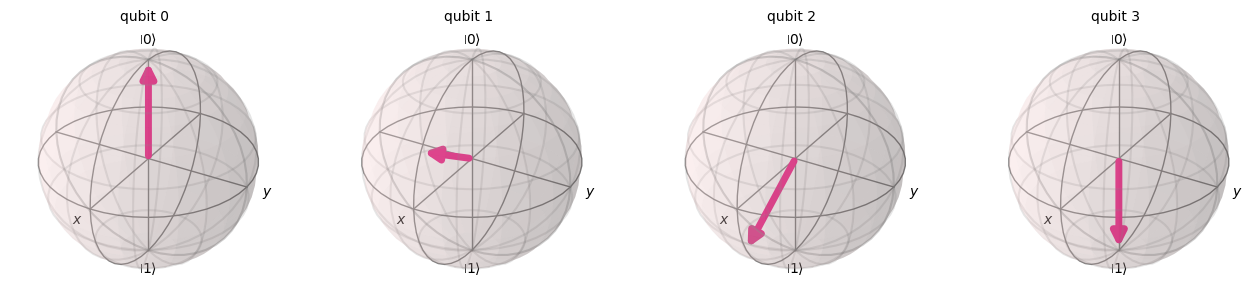

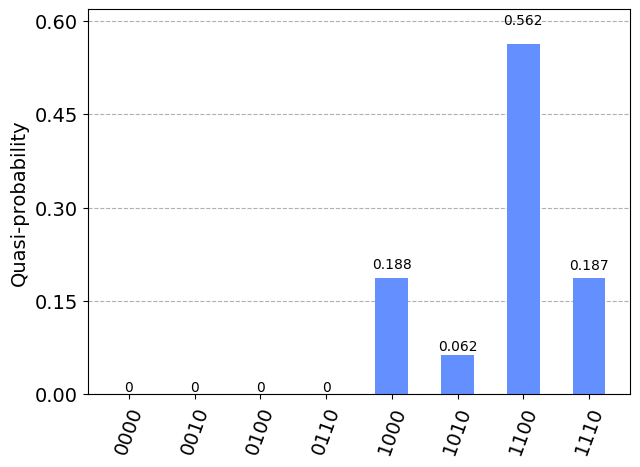

In [29]:
display(ql_StateVec.draw('latex'))
display(plot_bloch_multivector(ql_StateVec))
display(plot_histogram(ql_StateVec.probabilities_dict()))

In [57]:
# Experimenting Thresholding pixels based on intensity - WIP!
A = AncillaRegister(1, 'a')
circuit.add_register(A)

circuit.measure(0, 0)
circuit.cx(0, A[0])
circuit.cx(A[0], 0)
circuit.reset(A[0])
circuit.barrier()

circuit.measure(1, 1)
circuit.cx(1, A[0])
circuit.cx(A[0], 1)
circuit.reset(A[0])
circuit.barrier()

circuit.measure(2, 2)
circuit.cx(2, A[0])
circuit.cx(A[0], 2)
circuit.reset(A[0])
circuit.barrier()

circuit.measure(3, 3)
circuit.cx(3, A[0])
circuit.cx(A[0], 3)
circuit.reset(A[0])
circuit.barrier()

circuit.draw()

┌───────┐   ░ ┌─┐     ┌───┐      ░                    ░              »
q_0: ─┤ Ry(0) ├───░─┤M├──■──┤ X ├──────░────────────────────░──────────────»
     ┌┴───────┴┐  ░ └╥┘  │  └─┬─┘      ░ ┌─┐     ┌───┐      ░              »
q_1: ┤ Ry(π/3) ├──░──╫───┼────┼────────░─┤M├──■──┤ X ├──────░──────────────»
     ├─────────┴┐ ░  ║   │    │        ░ └╥┘  │  └─┬─┘      ░ ┌─┐     ┌───┐»
q_2: ┤ Ry(2π/3) ├─░──╫───┼────┼────────░──╫───┼────┼────────░─┤M├──■──┤ X ├»
     └┬───────┬─┘ ░  ║   │    │        ░  ║   │    │        ░ └╥┘  │  └─┬─┘»
q_3: ─┤ Ry(π) ├───░──╫───┼────┼────────░──╫───┼────┼────────░──╫───┼────┼──»
      └───────┘   ░  ║ ┌─┴─┐  │        ░  ║ ┌─┴─┐  │        ░  ║ ┌─┴─┐  │  »
  a: ────────────────╫─┤ X ├──■───|0>──░──╫─┤ X ├──■───|0>──░──╫─┤ X ├──■──»
                     ║ └───┘           ░  ║ └───┘           ░  ║ └───┘     »
c: 4/════════════════╩════════════════════╩════════════════════╩═══════════»
                     0                    1                    2           »
«           ░                    ░ 
«q_0: ──────░────────────────────░─
«           ░                    ░ 
«q_1: ──────░────────────────────░─
«           ░                    ░ 
«q_2: ──────░────────────────────░─
«           ░ ┌─┐     ┌───┐      ░ 
«q_3: ──────░─┤M├──■──┤ X ├──────░─
«           ░ └╥┘┌─┴─┐└─┬─┘      ░ 
«  a: ─|0>──░──╫─┤ X ├──■───|0>──░─
«           ░  ║ └───┘           ░ 
«c: 4/═════════╩═══════════════════
«              3

<IPython.core.display.Latex object>

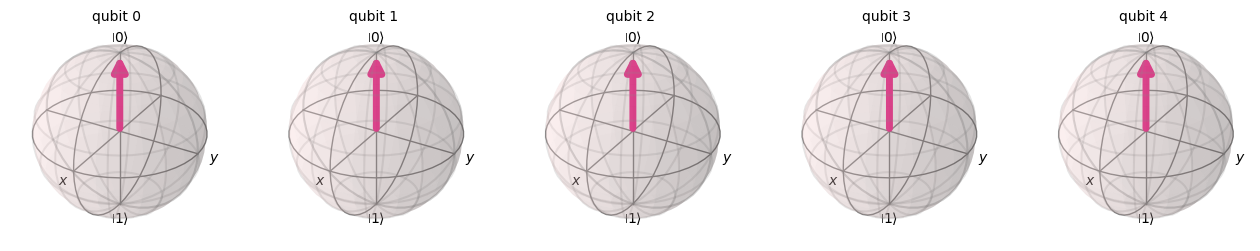

In [54]:
ql_StateVec_2 = Statevector(circuit)
display(ql_StateVec_2.draw('latex'))
display(plot_bloch_multivector(ql_StateVec_2))

In [ ]:
display(ql_StateVec.draw('latex'))

display(plot_distribution(ql_StateVec.probabilities_dict()))

display(plot_bloch_multivector(ql_StateVec))
# circuit.measure(reversed(range(len(input_vector))), range(len(input_vector)))

In [48]:
threshTheta = np.pi/2 + getThresholdAngle(n = 0.25, verbose=True)

for i in range(circuit.num_qubits):
    circuit.ry(threshTheta, i)

circuit.barrier()
display(circuit.draw())

0.003079992797637052


┌───────┐   ░ ┌───┐ ░ ┌──────────┐ ░ 
q_0: ─┤ Ry(0) ├───░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
     ┌┴───────┴┐  ░ ├───┤ ░ ├──────────┤ ░ 
q_1: ┤ Ry(π/3) ├──░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
     ├─────────┴┐ ░ ├───┤ ░ ├──────────┤ ░ 
q_2: ┤ Ry(2π/3) ├─░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
     └┬───────┬─┘ ░ ├───┤ ░ ├──────────┤ ░ 
q_3: ─┤ Ry(π) ├───░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
      └───────┘   ░ └───┘ ░ └──────────┘ ░ 
c: 4/══════════════════════════════════════

In [ ]:
display(Statevector(circuit).draw('latex'))
plot_bloch_multivector(Statevector(circuit))

In [ ]:
plot_state_qsphere(Statevector(circuit))

In [ ]:
plot_distribution(Statevector(circuit).probabilities_dict())

Decoding is a complex process which is done classically after measurements. Initially, for each qubit, we will find the total count where that qubit has value '0'.

In [21]:
# invertPixels(qc = circuit)
# addMeasurements(qc = circuit)
stateVec = Statevector(circuit)
# circuit.measure(reversed(range(circuit.num_qubits)), range(circuit.num_qubits))
circuit.draw()

┌───────┐    ░ 
 q_0: ───┤ Ry(0) ├────░─
      ┌──┴───────┴──┐ ░ 
 q_1: ┤ Ry(0.16016) ├─░─
      ├─────────────┤ ░ 
 q_2: ┤ Ry(0.32032) ├─░─
      └┬────────────┤ ░ 
 q_3: ─┤ Ry(0.4928) ├─░─
      ┌┴────────────┤ ░ 
 q_4: ┤ Ry(0.65296) ├─░─
      ├─────────────┤ ░ 
 q_5: ┤ Ry(0.82544) ├─░─
      └┬────────────┤ ░ 
 q_6: ─┤ Ry(0.9856) ├─░─
       ├────────────┤ ░ 
 q_7: ─┤ Ry(1.1458) ├─░─
       ├────────────┤ ░ 
 q_8: ─┤ Ry(1.3182) ├─░─
       ├────────────┤ ░ 
 q_9: ─┤ Ry(1.4784) ├─░─
       ├────────────┤ ░ 
q_10: ─┤ Ry(1.6509) ├─░─
       ├───────────┬┘ ░ 
q_11: ─┤ Ry(1.811) ├──░─
       ├───────────┴┐ ░ 
q_12: ─┤ Ry(1.9835) ├─░─
       ├────────────┤ ░ 
q_13: ─┤ Ry(2.1437) ├─░─
       ├────────────┤ ░ 
q_14: ─┤ Ry(11π/15) ├─░─
       ├────────────┤ ░ 
q_15: ─┤ Ry(2.4763) ├─░─
       ├────────────┤ ░ 
q_16: ─┤ Ry(2.6365) ├─░─
       ├───────────┬┘ ░ 
q_17: ─┤ Ry(2.809) ├──░─
       ├───────────┴┐ ░ 
q_18: ─┤ Ry(2.9691) ├─░─
       └─┬───────┬──┘ ░ 
q_19: ───┤ Ry(π) ├────░─
         └───────┘    ░ 
c: 20/══════════════════

In [22]:
import sys

stateVec.probabilities_dict()
print(sys.getsizeof(stateVec.probabilities_dict()))

20971608


In [78]:
''' Noisy model from AER: https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.NoiseModel.html '''
# # Get a fake backend from the fake provider
# backend = FakeMumbai()
# noise_model = NoiseModel.from_backend(backend)

# # Get coupling map from backend
# coupling_map = backend.configuration().coupling_map

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

# backend = AerSimulator(noise_model=noise_model,
#                        coupling_map=coupling_map,
#                        basis_gates=basis_gates)

''' Noisy model from QiskitRuntimeService: https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/dev/fake_provider '''
service = QiskitRuntimeService(channel="ibm_quantum", token="b58f04be6f1a8412295c8b59c3e19af21d1c9501d28ca176687d5c3f49338f0211c08461348a978c07dcecc76de10675f84deb366634b56c3a8ac0514085be5c")
backend = service.get_backend('ibm_brisbane')
backend = AerSimulator.from_backend(backend)

''' Pure simulator '''
# backend = AerSimulator()


' Pure simulator '

0.020923376083374023
{'0111': 1899, '0011': 5654, '0001': 1842, '0101': 605} {'0000': 7.030123981227463e-34, '0010': 2.3433746604091525e-34, '0100': 2.109037194368237e-33, '0110': 7.030123981227455e-34, '1000': 0.1875000000000001, '1010': 0.0625, '1100': 0.5625, '1110': 0.18749999999999992}


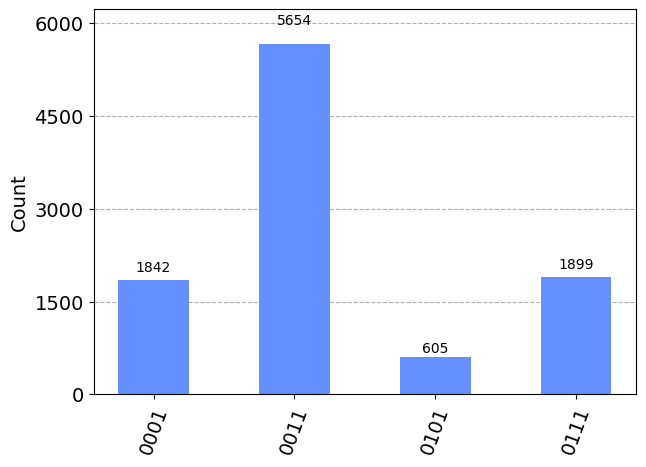

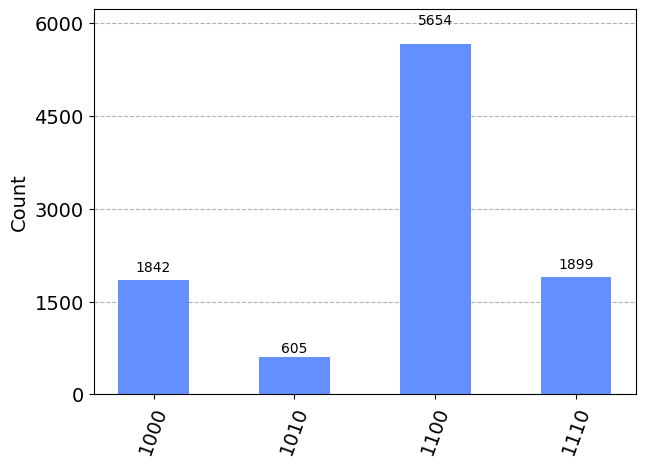

0.9999577305988109

In [34]:
shots = 10000
counts, result = simulate(qc = circuit, verbose=False, shots=shots)

print(result.time_taken)
# print(result.__dict__)

print(counts, ql_StateVec.probabilities_dict())


new_count = {}
for key, value in counts.items():
    new_count[key[::-1]] = value

display(plot_histogram(counts))
display(plot_histogram(new_count))

hellinger_fidelity(counts, ql_StateVec.probabilities_dict())
hellinger_fidelity(new_count, ql_StateVec.probabilities_dict())
# display(plot_histogram(ql_StateVec.probabilities_dict()))

In [39]:
for  iq in range(len(input_vector)):
    marCnt=marginal_distribution(counts,[iq])
    print('iq:',iq,marCnt)

iq: 0 {'0': 10000}
iq: 1 {'0': 10000}
iq: 2 {'0': 10000}
iq: 3 {'0': 10000}


In [40]:
# DECODE
output_values = np.zeros((len(input_vector)))

for item in counts:    
    print(item, counts[item])
    for i, bit in enumerate(item):
        if bit == '0':
            output_values[i] += counts[item]

print("q0, q1, q2, q3 : ", output_values)

0000 10000
q0, q1, q2, q3 :  [10000. 10000. 10000. 10000.]


Steps for reconstruction:
1. Find the _value / shots_ ratio
2. Take the square root of this ratio
3. Calculate _arccos_ and double the value

$$
output = 2 \times \arccos{(\sqrt{\frac{value}{shots}})}
$$
This ratio $value/shots$ is essentially the the conditional probability of observing a state given that the qubit associated selected pixel is in state $|0\rangle$.

4. Interpolate back from (0, $\pi$) to (0, 255)


In [41]:
# RECONSTRUCT
for i, value in enumerate(output_values):
    print(f"\nFor pixel {i}:")
    print(f"\tvalue/shots = {value}/{shots} = {value/shots}")
    print(f"\tsqrt(value/shots) = {(value/shots)**(1/2)}")
    print(f"\tarccos = {np.arccos((value/shots)**(1/2))}")
    print(f"\t2 * arccos = {2*np.arccos((value/shots)**(1/2))}")

# step 1,2,3
reconstruct = [2*np.arccos((value/shots)**(1/2)) for value in output_values]

# step 4
reconstruct = np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int)

print(f"\nOriginal values: {input_vector}\nReconstructed Inverted values: {reconstruct}")


For pixel 0:
	value/shots = 10000.0/10000 = 1.0
	sqrt(value/shots) = 1.0
	arccos = 0.0
	2 * arccos = 0.0

For pixel 1:
	value/shots = 10000.0/10000 = 1.0
	sqrt(value/shots) = 1.0
	arccos = 0.0
	2 * arccos = 0.0

For pixel 2:
	value/shots = 10000.0/10000 = 1.0
	sqrt(value/shots) = 1.0
	arccos = 0.0
	2 * arccos = 0.0

For pixel 3:
	value/shots = 10000.0/10000 = 1.0
	sqrt(value/shots) = 1.0
	arccos = 0.0
	2 * arccos = 0.0

Original values: [  0  85 170 255]
Reconstructed Inverted values: [0 0 0 0]


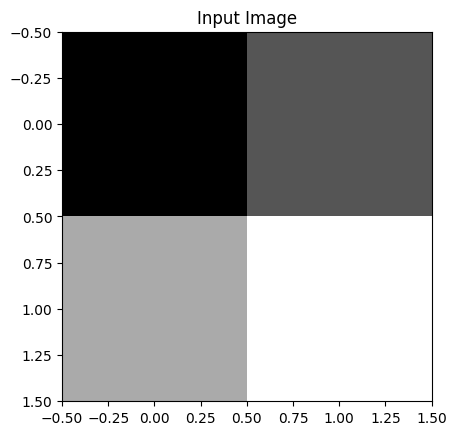

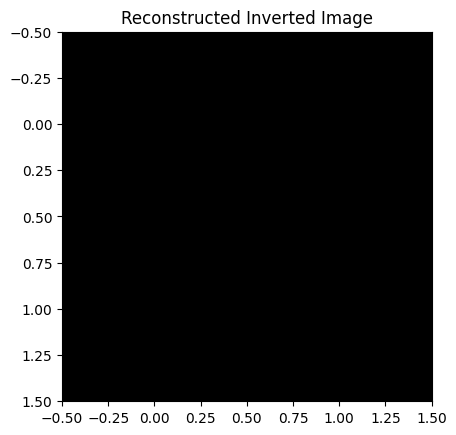

In [43]:
def plot_to_compare(input_vector, reconstruct):
    plt.imshow(np.reshape(input_vector, (2, 2)), cmap = 'gray')
    plt.title('Input Image')
    plt.show()
    plt.imshow(np.reshape(reconstruct, (2, 2)), cmap = 'gray')
    plt.title('Reconstructed Inverted Image')
    plt.show()

plot_to_compare(input_vector, reconstruct)

The Qubit Lattice model served as a base model for quantum encoding for image processing. Several other models like SQR and FRQI are based on this model.